In [60]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
from diffusers import UNet2DModel

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [62]:
# Transformations
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1),
    ]
)

undo_transform = transforms.Compose(
    [
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: (t * 255.0).numpy().astype(np.uint8)),
    ]
)

In [63]:
class diffusion:
    def __init__(self, timesteps, scheduler_type=None):
        betas = torch.linspace(0.0001, 0.02, timesteps)

        alphas = 1 - betas
        sqrt_alphas = torch.sqrt(alphas)
        alpha_hats = torch.cumprod(1 - betas, axis=0)
        sqrt_alpha_hats = torch.sqrt(alpha_hats)

        sqrt_one_minus_alpha_hats = torch.sqrt(1 - alpha_hats)

        self.betas = betas
        self.alphas = alphas
        self.sqrt_alphas = sqrt_alphas
        self.alpha_hats = alpha_hats
        self.sqrt_alpha_hats = sqrt_alpha_hats
        self.sqrt_one_minus_alpha_hats = sqrt_one_minus_alpha_hats

    def noise_schedule(self, x_0, t, device="cpu"):
        noise = torch.randn(size=x_0.shape)

        alpha_hats_t = self.alpha_hats[t]
        alpha_hats_t = alpha_hats_t.reshape(shape=(t.shape[0], 1, 1, 1))

        sqrt_alpha_hats_t = self.sqrt_alpha_hats[t]
        sqrt_alpha_hats_t = sqrt_alpha_hats_t.reshape(shape=(t.shape[0], 1, 1, 1))

        sqrt_one_minus_alpha_hats_t = self.sqrt_one_minus_alpha_hats[t]
        sqrt_one_minus_alpha_hats_t = sqrt_one_minus_alpha_hats_t.reshape(
            shape=(t.shape[0], 1, 1, 1)
        )

        mean = sqrt_alpha_hats_t * x_0
        variance = sqrt_one_minus_alpha_hats_t * noise

        x_ts = mean + variance

        return x_ts.to(device), noise.to(device)

    @torch.no_grad()
    def sample(self, x_t, t, prediction):
        x_t = x_t.cpu()
        t = t.cpu()
        prediction = prediction.cpu()

        betas_t = self.betas[t]
        sqrt_alphas_t = self.sqrt_alphas[t]

        sqrt_one_minus_alpha_hats_t = self.sqrt_one_minus_alpha_hats[t]

        x_t_minus_one = (1 / sqrt_alphas_t) * (
            x_t - ((betas_t * prediction) / sqrt_one_minus_alpha_hats_t)
        )

        if t == 0:
            return x_t_minus_one
        else:
            noise = torch.randn_like(x_t)
            return x_t_minus_one + torch.sqrt(betas_t) * noise
        
    def create_image(self, model, img_size=32, timesteps=300):
        with torch.no_grad():
            img = torch.randn((1, 1, img_size, img_size))
            plt.figure(figsize=(15, 2))
            plt.axis("off")
            num_images = 10
            stepsize = int(timesteps / num_images)

            for i in range(0, timesteps)[::-1]:
                t = torch.full((1,), i, dtype=torch.long)

                img = img.to(device)
                t = t.to(device)

                prediction = model(img, t).sample

                img = self.sample(img, t, prediction)

                img = torch.clamp(img, -1.0, 1.0)
                if i % stepsize == 0:
                    plt.subplot(1, num_images, int(i / stepsize) + 1)
                    plt.imshow(undo_transform(img.cpu()[0]))
            plt.show()

In [64]:
image_data = torchvision.datasets.QMNIST("./data", download=True, transform=transform)
# data_loader = torch.utils.data.DataLoader(image_data, batch_size=16, shuffle=True)
# images, labels = next(iter(data_loader))

In [65]:
BATCH_SIZE = 128
NO_EPOCHS = 10
TIME_STEPS = 300

diffuser = diffusion(timesteps=TIME_STEPS)

Epoch 0 | step 000 Loss: 1.032761573791504 
Using 3.34 GB


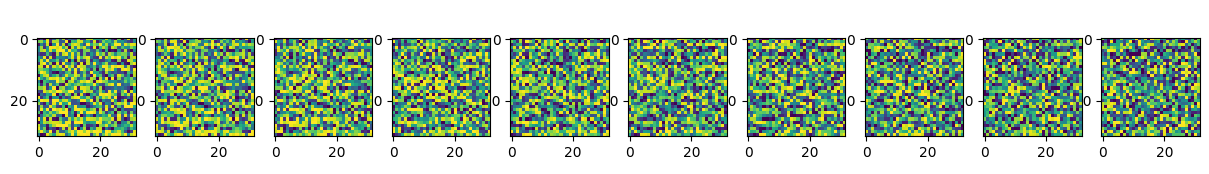

Epoch 0 | step 100 Loss: 0.1270696222782135 
Using 3.34 GB


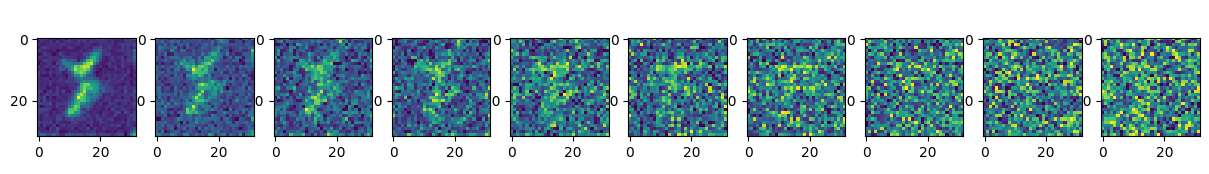

Epoch 0 | step 200 Loss: 0.07046106457710266 
Using 3.34 GB


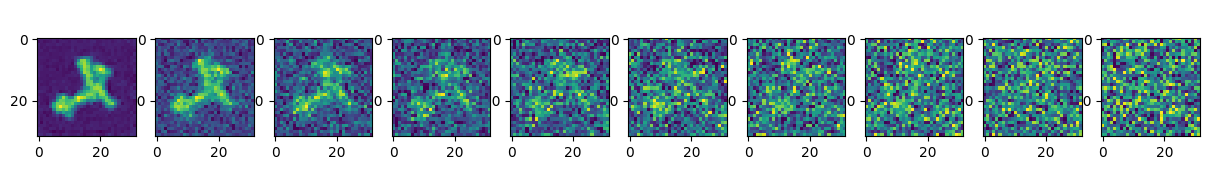

Epoch 0 | step 300 Loss: 0.05846155807375908 
Using 3.34 GB


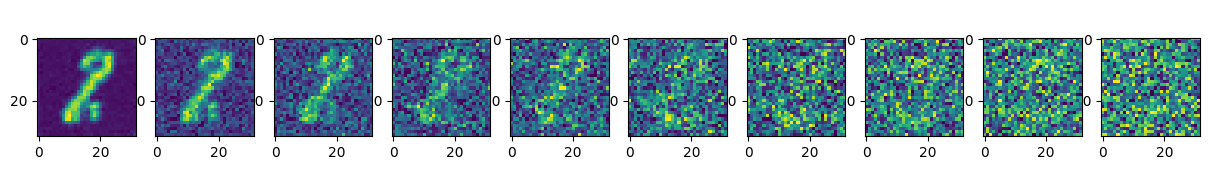

Epoch 0 | step 400 Loss: 0.04915110766887665 
Using 3.34 GB


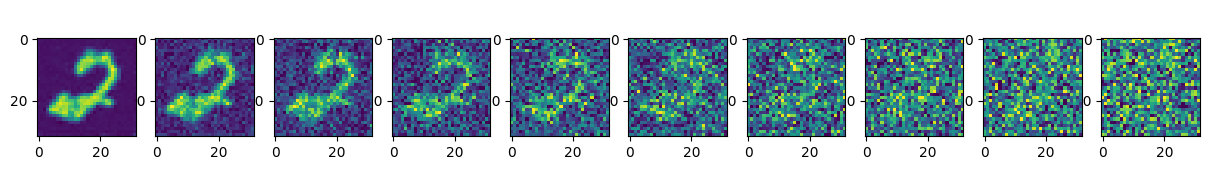

Epoch 1 | step 000 Loss: 0.05212048441171646 
Using 3.34 GB


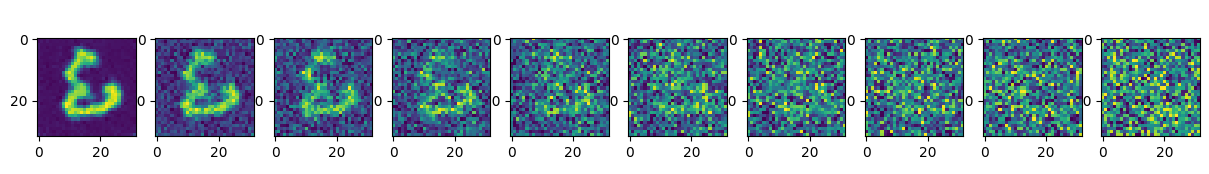

Epoch 1 | step 100 Loss: 0.04536432772874832 
Using 3.34 GB


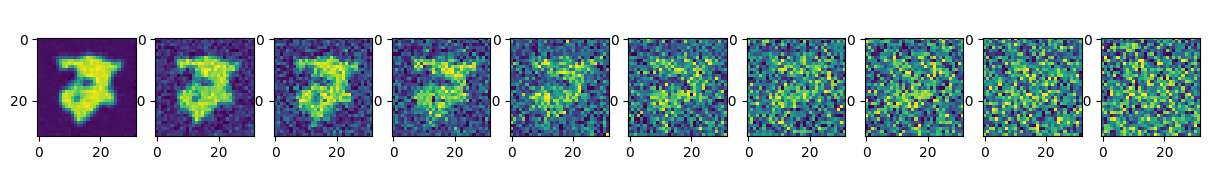

Epoch 1 | step 200 Loss: 0.04770037531852722 
Using 3.34 GB


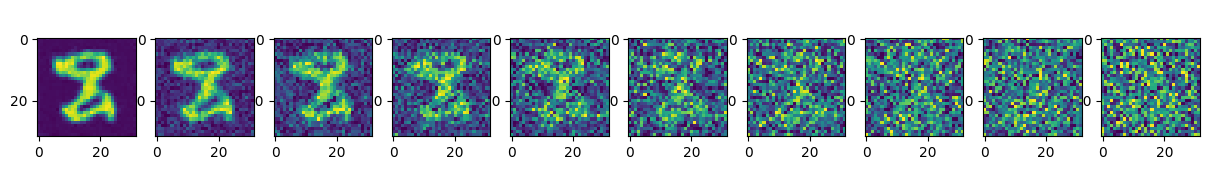

Epoch 1 | step 300 Loss: 0.04135483503341675 
Using 3.34 GB


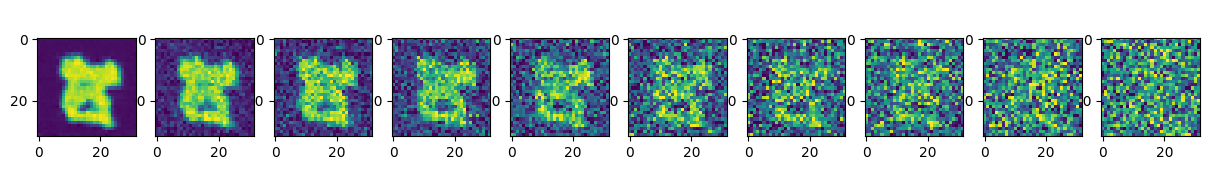

Epoch 1 | step 400 Loss: 0.05322716012597084 
Using 3.34 GB


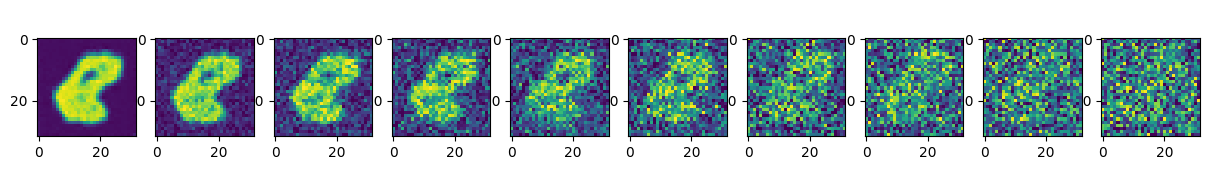

Epoch 2 | step 000 Loss: 0.04827382415533066 
Using 3.34 GB


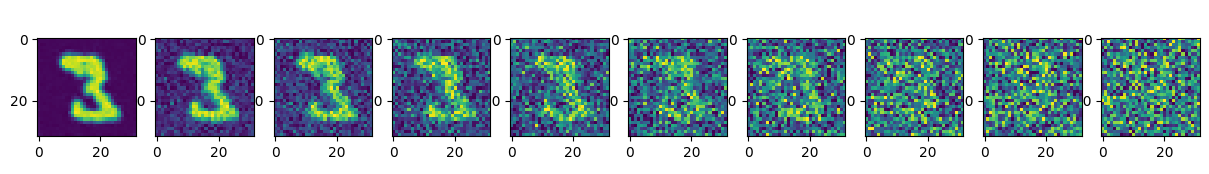

Epoch 2 | step 100 Loss: 0.03819674998521805 
Using 3.34 GB


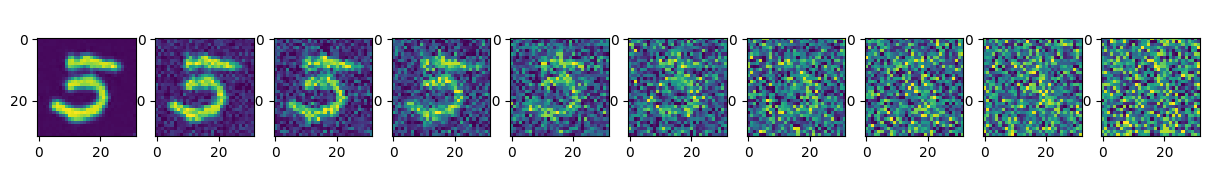

Epoch 2 | step 200 Loss: 0.041417233645915985 
Using 3.34 GB


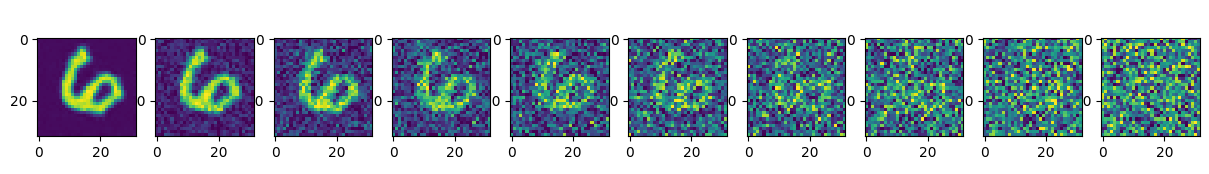

Epoch 2 | step 300 Loss: 0.04305493086576462 
Using 3.34 GB


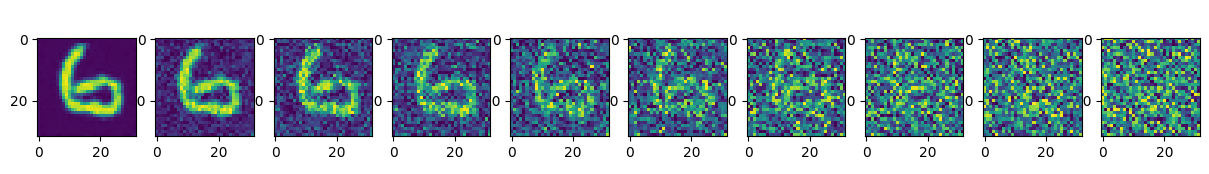

Epoch 2 | step 400 Loss: 0.029537932947278023 
Using 3.34 GB


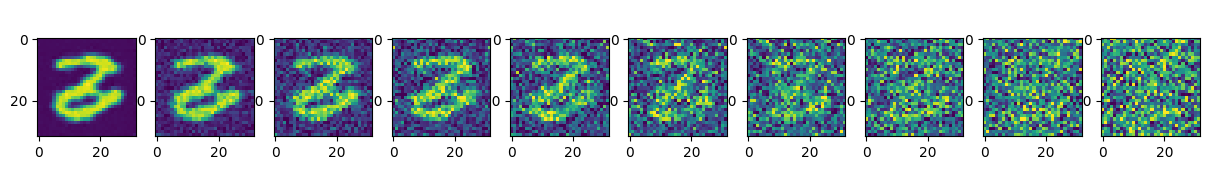

Epoch 3 | step 000 Loss: 0.04037740081548691 
Using 3.34 GB


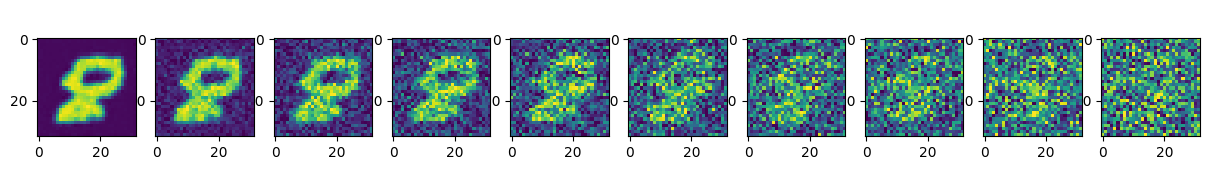

Epoch 3 | step 100 Loss: 0.04244248569011688 
Using 3.34 GB


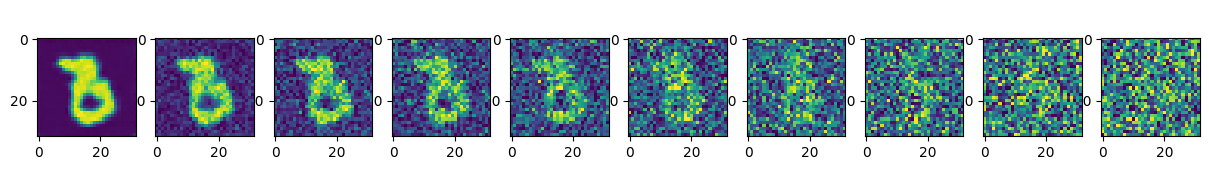

Epoch 3 | step 200 Loss: 0.037597477436065674 
Using 3.34 GB


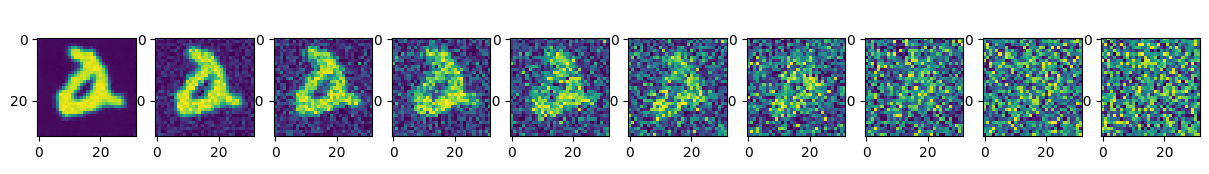

Epoch 3 | step 300 Loss: 0.03893553093075752 
Using 3.34 GB


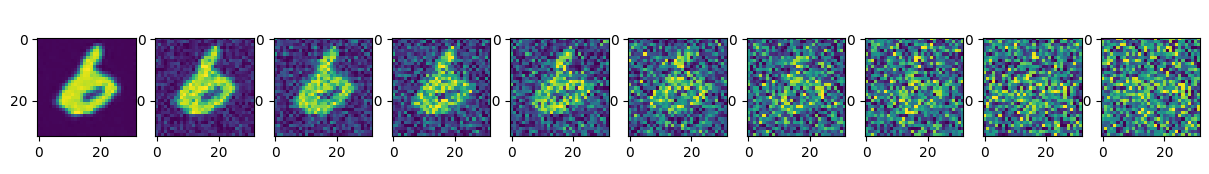

Epoch 3 | step 400 Loss: 0.03586255759000778 
Using 3.34 GB


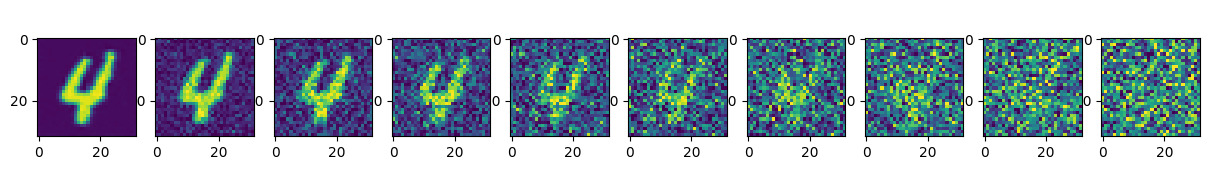

Epoch 4 | step 000 Loss: 0.03192553296685219 
Using 3.34 GB


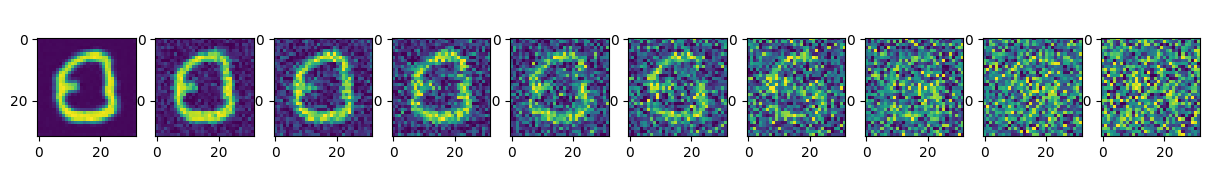

Epoch 4 | step 100 Loss: 0.03661327809095383 
Using 3.34 GB


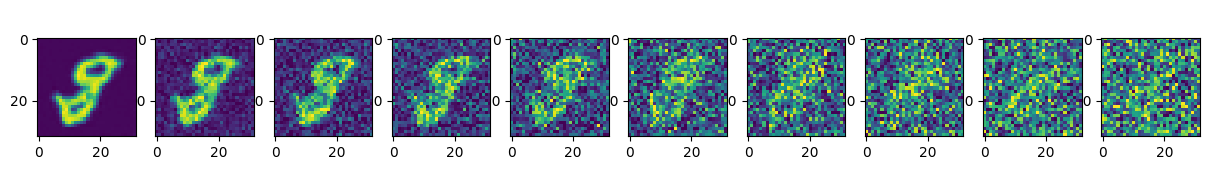

Epoch 4 | step 200 Loss: 0.03809382766485214 
Using 3.34 GB


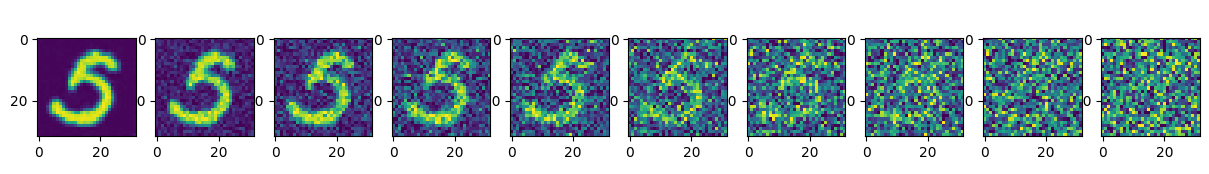

Epoch 4 | step 300 Loss: 0.03585486859083176 
Using 3.34 GB


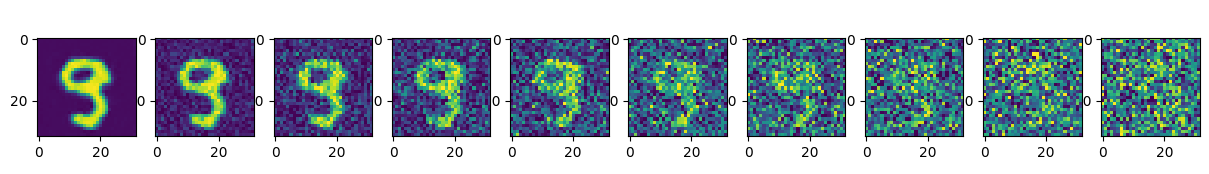

Epoch 4 | step 400 Loss: 0.041152458637952805 
Using 3.34 GB


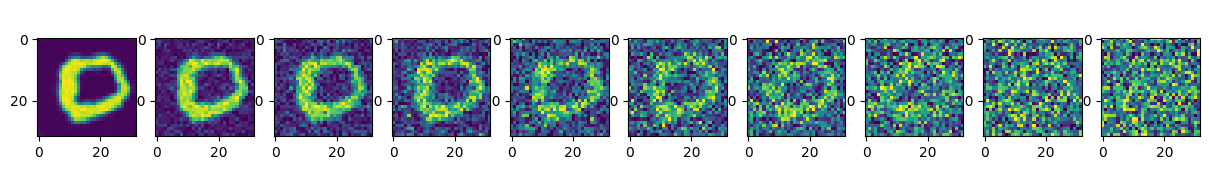

Epoch 5 | step 000 Loss: 0.03541868180036545 
Using 3.34 GB


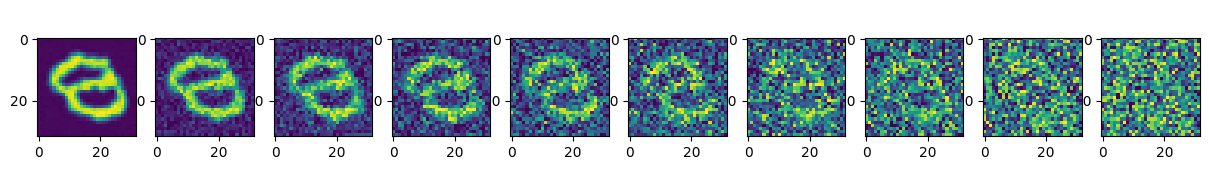

Epoch 5 | step 100 Loss: 0.031893040984869 
Using 3.34 GB


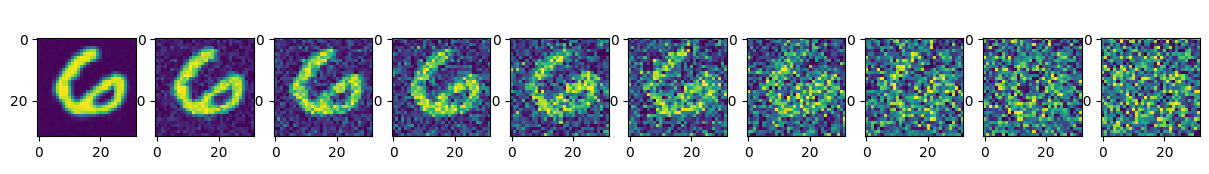

Epoch 5 | step 200 Loss: 0.030469100922346115 
Using 3.34 GB


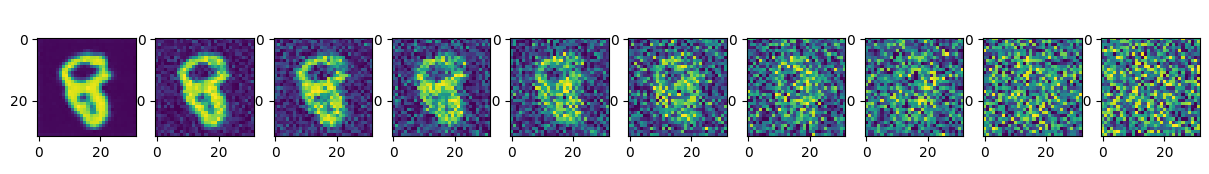

Epoch 5 | step 300 Loss: 0.029946155846118927 
Using 3.34 GB


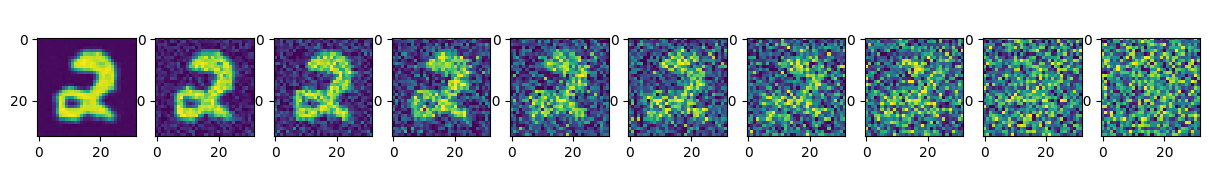

Epoch 5 | step 400 Loss: 0.03284040093421936 
Using 3.34 GB


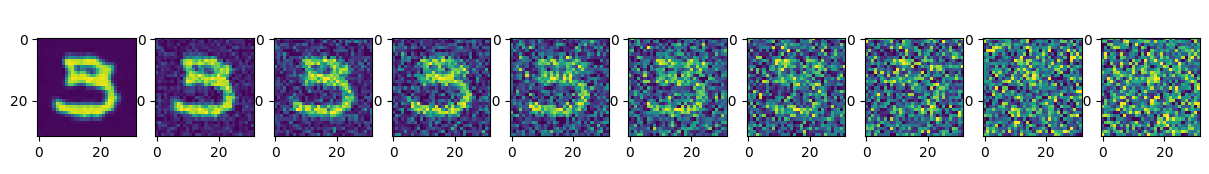

Epoch 6 | step 000 Loss: 0.033471450209617615 
Using 3.34 GB


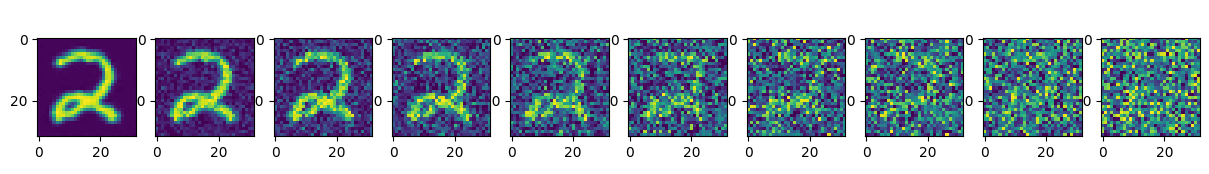

Epoch 6 | step 100 Loss: 0.031750284135341644 
Using 3.34 GB


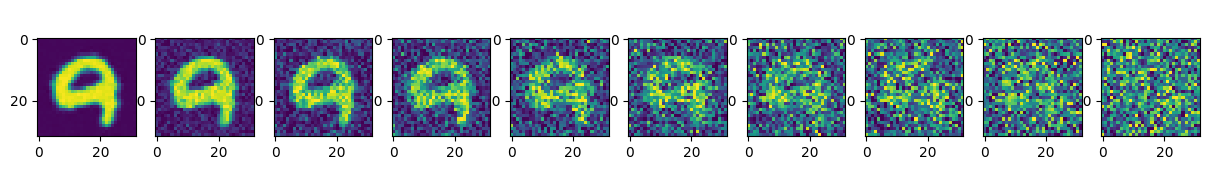

Epoch 6 | step 200 Loss: 0.028006142005324364 
Using 3.34 GB


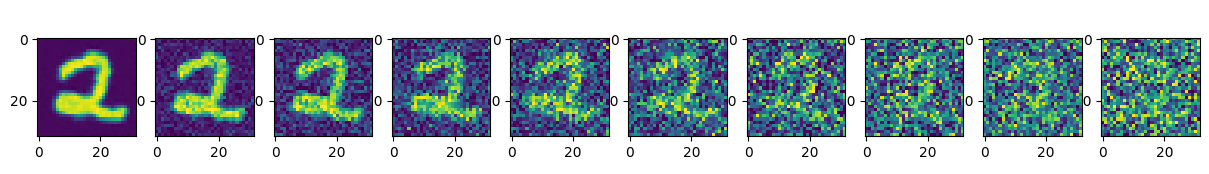

Epoch 6 | step 300 Loss: 0.03424830734729767 
Using 3.34 GB


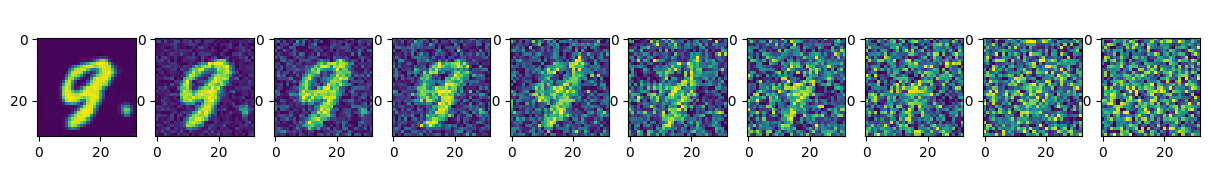

Epoch 6 | step 400 Loss: 0.026276618242263794 
Using 3.34 GB


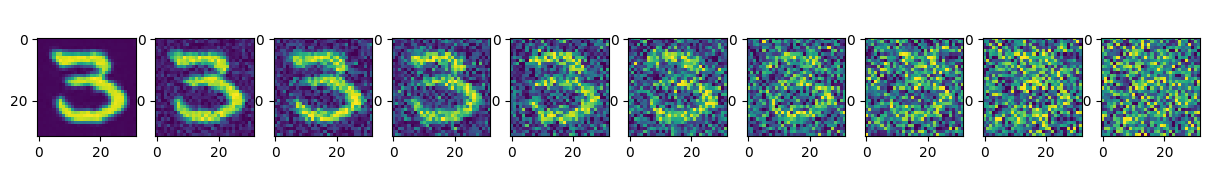

Epoch 7 | step 000 Loss: 0.02905651554465294 
Using 3.34 GB


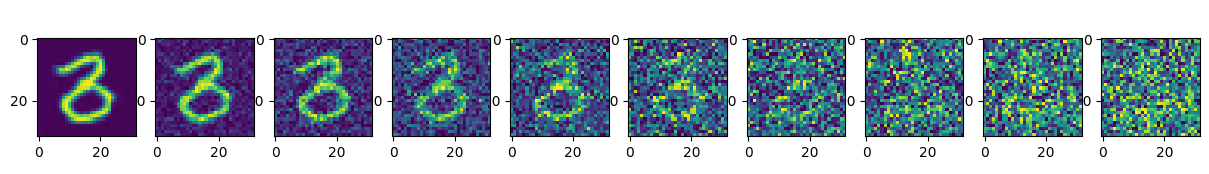

Epoch 7 | step 100 Loss: 0.03285934031009674 
Using 3.34 GB


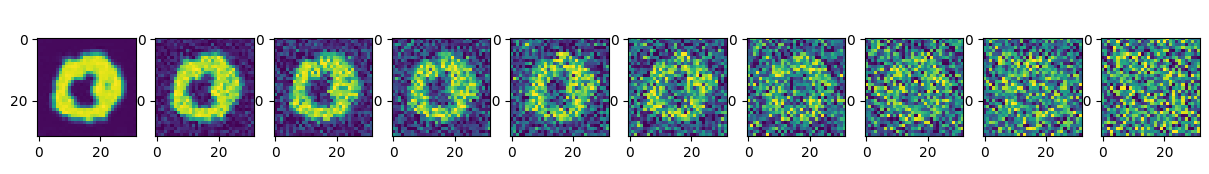

Epoch 7 | step 200 Loss: 0.027903184294700623 
Using 3.34 GB


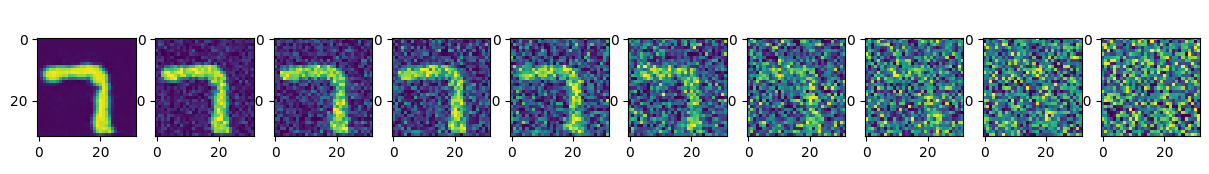

Epoch 7 | step 300 Loss: 0.027024025097489357 
Using 3.34 GB


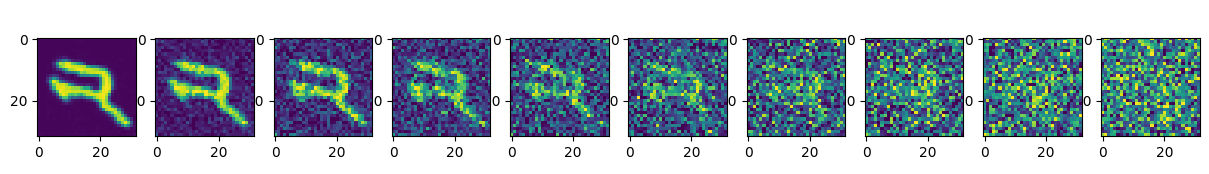

Epoch 7 | step 400 Loss: 0.029648292809724808 
Using 3.34 GB


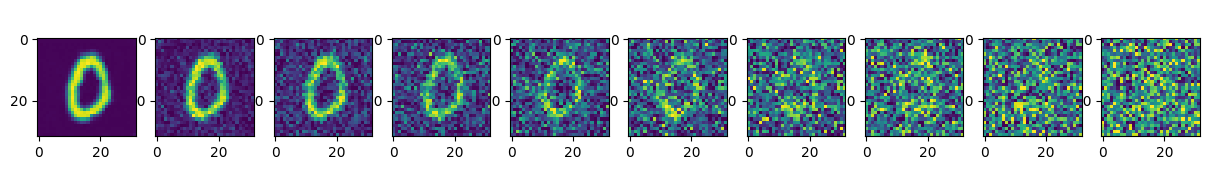

Epoch 8 | step 000 Loss: 0.0282369926571846 
Using 3.34 GB


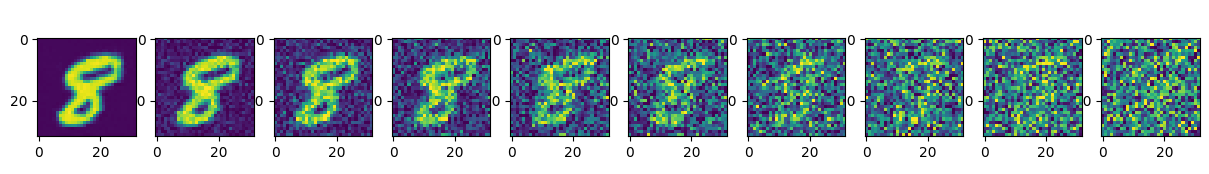

Epoch 8 | step 100 Loss: 0.028097866103053093 
Using 3.34 GB


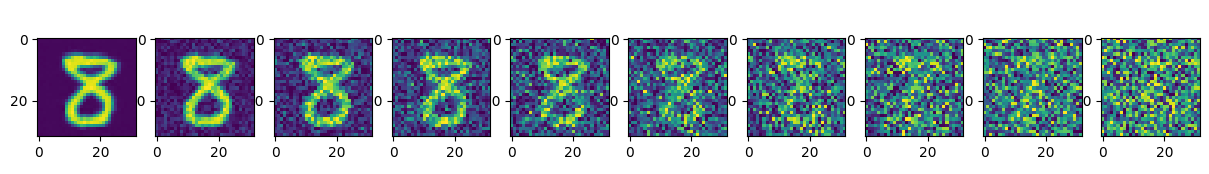

Epoch 8 | step 200 Loss: 0.030822549015283585 
Using 3.34 GB


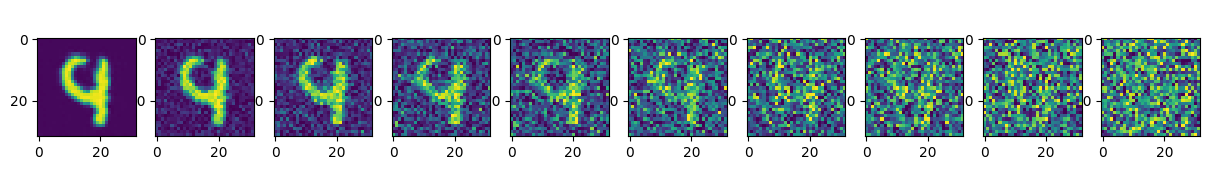

Epoch 8 | step 300 Loss: 0.030435379594564438 
Using 3.34 GB


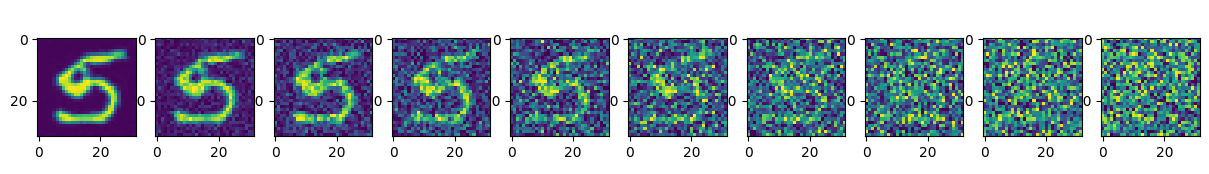

Epoch 8 | step 400 Loss: 0.028082041069865227 
Using 3.34 GB


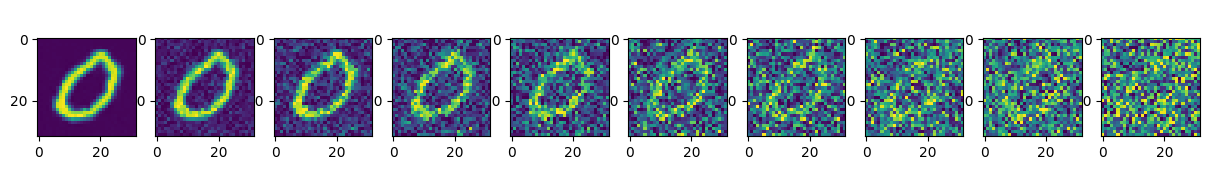

Epoch 9 | step 000 Loss: 0.033537738025188446 
Using 3.34 GB


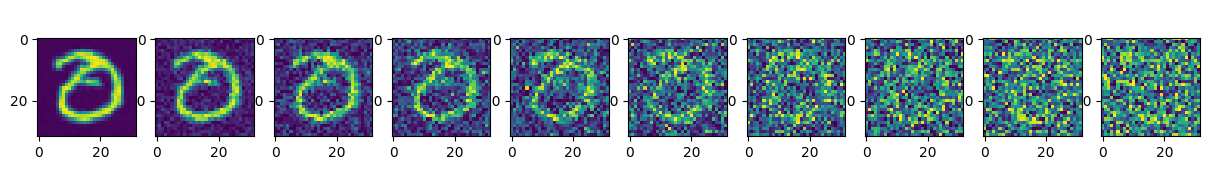

Epoch 9 | step 100 Loss: 0.03402213007211685 
Using 3.34 GB


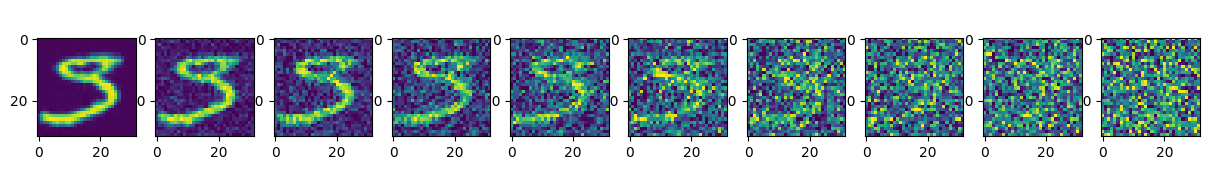

Epoch 9 | step 200 Loss: 0.032875217497348785 
Using 3.34 GB


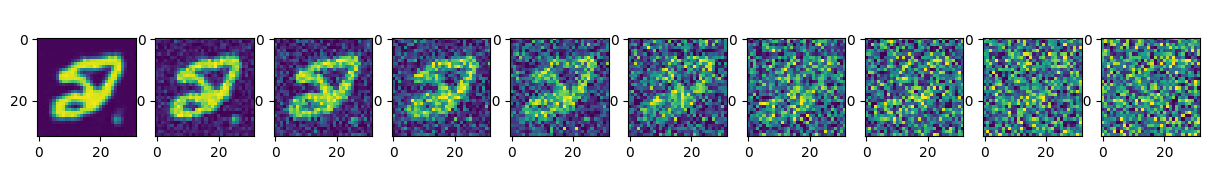

Epoch 9 | step 300 Loss: 0.034101150929927826 
Using 3.34 GB


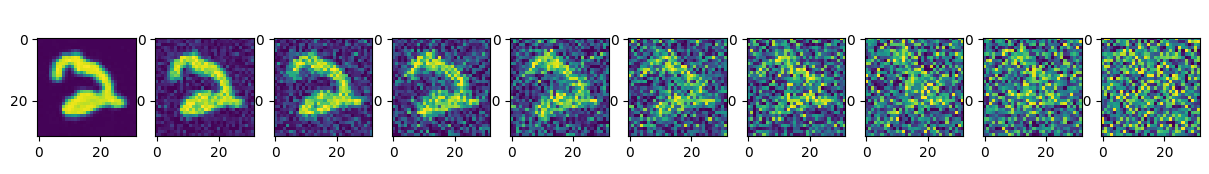

Epoch 9 | step 400 Loss: 0.03850521892309189 
Using 3.34 GB


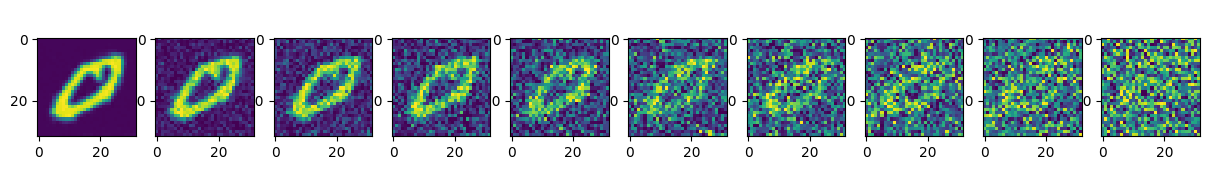

In [66]:
# model = UNet2DModel(
#     sample_size=32,  # the target image resolution
#     in_channels=3,  # the number of input channels, 3 for RGB images
#     out_channels=3,  # the number of output channels
#     layers_per_block=2,  # how many ResNet layers to use per UNet block
#     block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
#     down_block_types=(
#         "DownBlock2D",  # a regular ResNet downsampling block
#         "DownBlock2D",
#         "DownBlock2D",
#         "DownBlock2D",
#         "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
#         "DownBlock2D",
#     ),
#     up_block_types=(
#         "UpBlock2D",  # a regular ResNet upsampling block
#         "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
#         "UpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D",
#         "UpBlock2D",
#     ),
# )

model = UNet2DModel(
    in_channels=1,
    out_channels=1,
    sample_size=32,
    block_out_channels=(32, 64, 128, 256),
    norm_num_groups=8,
)


model.to(device)

dataloader = torch.utils.data.DataLoader(
    image_data, batch_size=BATCH_SIZE, shuffle=True
)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(NO_EPOCHS):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, TIME_STEPS, (len(batch[0]),), device=device).long()

        img_batch_noisy, noise_batch = diffuser.noise_schedule(
            x_0=batch[0], t=t.cpu(), device=device
        )

        predicted_noise_batch = model(img_batch_noisy, t)

        loss = loss_fn(predicted_noise_batch.sample, noise_batch)

        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            print(f"Using {torch.cuda.mem_get_info()[0]/1000000000:.2f} GB")
            diffuser.create_image(model, img_size=32, timesteps=TIME_STEPS)

model.save_pretrained("model_MNIST_checkpoint", from_pt=True)

In [69]:
model_new = UNet2DModel().from_pretrained('./model_MNIST_checkpoint/')
model_new = model_new.to(device)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(

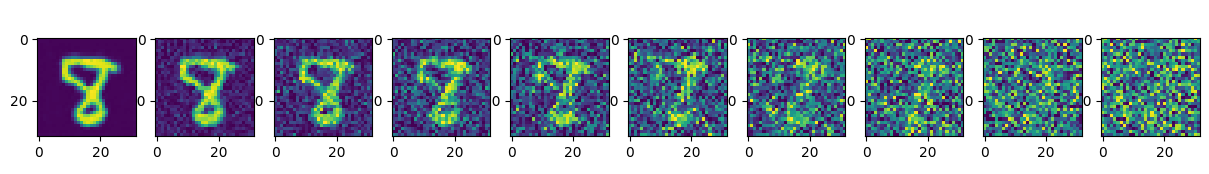

In [75]:
diffuser.create_image(model_new, img_size=32, timesteps=TIME_STEPS)